## Лабораторна робота 5 - Штучні нейронні мережі.

У цій роботі Ви побудуєте нейронну мережу для класифікації зображень рукописних символів за датасетом MNIST.

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

У файлі **mnist.npz** міститься датасет MNIST. Завантажимо його та візуалізуємо.

x_train shape: (60000, 28, 28)
x_test shape: (10000, 28, 28)


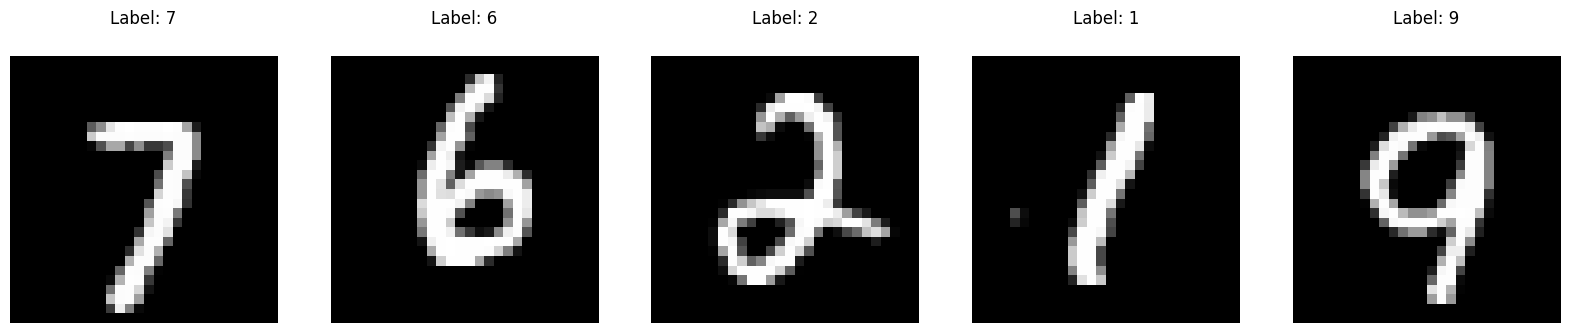

In [75]:
with np.load('mnist.npz') as npz:
    x_train, y_train, x_test, y_test = [npz[k] for k in ['x_train', 'y_train', 'x_test', 'y_test']]

fig, ax = plt.subplots(figsize=(20, 4),  ncols=5)
for a in ax:
    i = np.random.randint(x_train.shape[0])
    a.matshow(x_train[i], cmap='gray')
    a.set_title(f'Label: {y_train[i]}')
    a.axis('off')
    
print(f'x_train shape: {x_train.shape}')
print(f'x_test shape: {x_test.shape}')


Для більш ефективного зберігання, інтенсивності пікселів представлені цілочисельним типом uint8, який, на жаль, не підходить для виконання (оскільки він цілочисельний). Перетворюємо дані в float32.

In [76]:
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

Створемо нейромережу

In [77]:
model = Sequential([
    Flatten(input_shape=(28, 28)),  # Перетворюємо зображення 28x28 у вектор
    Dense(128, activation='relu'),  # Прихований шар з 128 нейронів
    Dense(10, activation='softmax')  # Останній шар з 10 нейронами (по одному для кожної цифри)
])

model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])


In [78]:
model.fit(x_train, y_train, epochs=10, batch_size=32)
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_acc * 100}%')

Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 2.2414 - accuracy: 0.8418
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3657 - accuracy: 0.9057
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2802 - accuracy: 0.9258
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2449 - accuracy: 0.9359
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2167 - accuracy: 0.9443
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2082 - accuracy: 0.9481
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2042 - accuracy: 0.9507
Epoch 8/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1897 - accuracy: 0.9533
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1789 - accuracy: 0.9563
Epoch 10/10
313/313 [==============================] - 1s 1ms/step - loss: 0.2714 